In [214]:
import logging
logging.basicConfig(
    level=logging.INFO,
    handlers=[logging.FileHandler(filename='Risultati2.log')])
loggerTotali = logging.getLogger('Dataset_tot')

In [186]:
import pandas as pd
dataset = pd.read_excel('IncidentiModificato.xlsx', sheet_name='Foglio1', index_col=0)
dataset.head()

,DATA,SESSO,ANNI,PESO,ALTEZZA,BMI,Mezzo,Testa:Neurocranio,Testa:Splancnocranio,Testa:Telencefalo,...,Scheletro:Rachide-cervicale,Scheletro:Rachide-toracico,Scheletro:Rachide-lombare,Scheletro:Bacino-e-sacro,Scheletro:Complesso-sterno/claveo/costale,Tot Testa,Tot Torace,Tot Addome,Tot Scheletro,Totale
VERBALE,,,,,,,,,,,,,,,,,,,,,
85567,1999-10-29,0,81,84.0,1.75,27.428571,0,1,0,0,...,0,3,0,3,3,2,0,3,9,14
85829,2000-01-14,1,69,69.0,1.62,26.291724,1,4,4,4,...,0,0,0,0,4,20,7,1,4,32
85977,2000-03-10,1,71,67.0,1.55,27.887617,1,2,0,1,...,0,0,0,0,4,6,0,0,4,10
86220,2000-06-14,1,54,60.0,1.59,23.733238,1,4,0,0,...,0,0,0,0,4,5,3,2,4,14
86247,2000-06-22,1,78,69.0,1.67,24.740937,1,2,0,0,...,0,0,0,0,4,2,0,2,4,8


In [187]:
len(dataset)

130

In [188]:
dataset.index.unique()

Index([    85567,     85829,     85977,     86220,     86247,     86421,
           86839,     86876,     86878,     90056,
       ...
          101097,    101180,    101189,    101544,    101583,    101618,
       '101288E', 'E-97586',       'X',      'X1'],
      dtype='object', name='VERBALE', length=130)

In [189]:
def checkDataset(dataset):
    #controllo che i verbali siano valori unici
    if (len(dataset.index) != len(dataset.index.unique())):
        raise Exception('I verbali non possono essere usati come indice')

    #controllo i valori degli anni
    anni = dataset['ANNI']
    for anno in anni:
        if anno < 1 or anno > 95:
            raise Exception(f'Anno inserito non valido {anno}')
    
    #controllo i valori dei pesi
    pesi = dataset['PESO']
    for peso in pesi:
        if peso < 30 or peso > 120:
            raise Exception(f'Peso inserito non valido {peso}')
    
    #controllo i valori dell'altezza
    altezze = dataset['ALTEZZA']
    for altezza in altezze:
        if altezza < 1.00 or altezza > 2.10:
            raise Exception(f'Altezza inserito non valida {altezza}')
    
    #controllo del BMI
    valori_BMI = dataset['BMI']
    for bmi in valori_BMI:
        if bmi < 10.0 or bmi > 50.0:
            raise Exception(f'bmi inserito non valido {bmi}')
            
    #controllo altri valori compresi tra 0 e 4
    dataset_valori_0_4 = dataset['Testa:Neurocranio']
    for valore in dataset_valori_0_4:
        if valore < 0 or valore > 4:
            raise Exception(f'{valore} non compresa tra 0 e 4')
            

    print("Valori del dataset corretti")
    

checkDataset(dataset)

Valori del dataset corretti


In [190]:
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, cross_val_score
import time
from random import seed
import numpy as np


def addestra(model_class, X, y, model_selection_grid, num_fold_grid_search, num_fold_cross_val, scaling=StandardScaler(), dim_reduction=None):
    
    start_time = time.time()
    
    X_std = scaling.fit_transform(X) if scaling is not None else X
    
    X_std = dim_reduction.fit_transform(X_std) if dim_reduction is not None else X_std
    np.random.seed(42)
    clf = GridSearchCV(estimator=model_class(), param_grid=model_selection_grid, cv=num_fold_grid_search, n_jobs=-1)
    val = cross_val_score(clf, X_std, y, cv=num_fold_cross_val)
    print("--- %s seconds ---" % (time.time() - start_time))
    return val


## Iniziamo considerando solo i totali per distretto

In [191]:
X_total = dataset[['SESSO', 'ANNI', 'PESO', 'ALTEZZA', 'Tot Testa', 'Tot Torace', 'Tot Addome', 'Tot Scheletro']]
y_total = dataset['Mezzo']

In [192]:
risultati = {}

In [198]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier

models = [SVC, DecisionTreeClassifier, GaussianNB, LinearDiscriminantAnalysis, MLPClassifier]
model_to_string = {SVC: 'SVC', DecisionTreeClassifier: 'DT', GaussianNB: 'NB', LinearDiscriminantAnalysis: 'LD', MLPClassifier: 'MLP'}

c_space = np.logspace(-4, 3, 10)
gamma_space = np.logspace(-4, 3, 10)

model_selection_grid_SVC = [
  {'C': c_space, 'kernel': ['linear'], 'gamma': ['auto']},
  {'C': c_space, 'gamma': gamma_space, 'kernel': ['rbf']},
  {'C': c_space, 'gamma': ['auto', 'scale'], 'kernel': ['rbf']},
  {'C': c_space, 'degree': [2, 3, 5, 9], 'kernel': ['poly'], 'gamma': ['auto']},
 ]

model_selection_grid_DT = {'criterion': ['gini', 'entropy'],
                        'max_leaf_nodes': [None, 2, 5, 10, 50, 100],
                        'max_features': [None, 'sqrt', 'log2'],
                        'max_depth': [None, 2, 5, 10]}



model_selection_grid_RF = {'n_estimators': [5, 10, 50, 100, 200],
                        'criterion': ['gini', 'entropy'],
                        'max_leaf_nodes': [None, 2, 5, 10, 50, 100],
                        'max_features': [None, 'sqrt', 'log2'],
                        'max_depth': [None, 2, 5, 10]}

model_selection_grid_NB = {}
model_selection_grid_LD = {}

model_selection_grid_MLP = {'max_iter': [5000],
                        'hidden_layer_sizes': [[2], [4], [6], [10], [20], [4, 4], [10, 10]],
                        'activation': ['identity', 'logistic', 'tanh', 'relu']}

grids = [model_selection_grid_SVC, model_selection_grid_DT, model_selection_grid_NB, model_selection_grid_LD, model_selection_grid_MLP]

In [ ]:
risultati['Totali'] = {model_to_string[m]: np.mean(addestra(m, X_total, y_total, g, 9, 9)) for m, g in zip(models, grids)}
loggerTotali.info(risultati['Totali'])

--- 21.061282873153687 seconds ---
--- 5.182336807250977 seconds ---
--- 0.13790535926818848 seconds ---
--- 0.2228407859802246 seconds ---


In [213]:
loggerTotali.info(risultati['Totali'])


# Proviamo considerando anche il BMI

In [17]:
X_total_with_BMI = dataset[['SESSO', 'ANNI', 'PESO', 'ALTEZZA', 'BMI', 'Tot Testa', 'Tot Torace', 'Tot Addome', 'Tot Scheletro']]
y_total_with_BMI = dataset['Mezzo']

In [ ]:
table = pd.DataFrame(risultati)
table

In [13]:
risultati['Totali_with_BMI'] = {model_to_string[m]: np.mean(addestra(m, X_total_with_BMI, y_total_with_BMI, g, 9, 9)) for m, g in zip(models, grids)}
loggerTotali.info(risultati['Totali_with_BMI'])

--- 21.70437526702881 seconds ---
--- 5.2794740200042725 seconds ---
--- 1272.7486758232117 seconds ---
--- 0.1429576873779297 seconds ---
--- 0.2601203918457031 seconds ---
--- 205.8423206806183 seconds ---


In [14]:
table = pd.DataFrame(risultati)
table

,Totali,Totali_with_BMI
SVC,0.660847,0.668783
DT,0.576720,0.593122
RF,0.661905,0.646561
NB,0.692593,0.685714
LD,0.713228,0.689947
MLP,0.675661,0.676190


# Usiamo la DATA senza BMI

In [15]:
date_ordinate = dataset['DATA'].sort_values()
prima_data = date_ordinate.values[0]
print("La prima data del dataset è: ", prima_data)

La prima data del dataset è:  1999-10-29T00:00:00.000000000


In [52]:
import datetime as dt

dataset.DATA = dataset.DATA.apply(lambda d: (d - dt.datetime(1970,1,1)).days)

dataset.head()

,DATA,SESSO,ANNI,PESO,ALTEZZA,BMI,Mezzo,Testa:Neurocranio,Testa:Splancnocranio,Testa:Telencefalo,...,Scheletro:Rachide-cervicale,Scheletro:Rachide-toracico,Scheletro:Rachide-lombare,Scheletro:Bacino-e-sacro,Scheletro:Complesso-sterno/claveo/costale,Tot Testa,Tot Torace,Tot Addome,Tot Scheletro,Totale
VERBALE,,,,,,,,,,,,,,,,,,,,,
85567,10893,0,81,84.0,1.75,27.428571,0,1,0,0,...,0,3,0,3,3,2,0,3,9,14
85829,10970,1,69,69.0,1.62,26.291724,1,4,4,4,...,0,0,0,0,4,20,7,1,4,32
85977,11026,1,71,67.0,1.55,27.887617,1,2,0,1,...,0,0,0,0,4,6,0,0,4,10
86220,11122,1,54,60.0,1.59,23.733238,1,4,0,0,...,0,0,0,0,4,5,3,2,4,14
86247,11130,1,78,69.0,1.67,24.740937,1,2,0,0,...,0,0,0,0,4,2,0,2,4,8


In [54]:
X_total_with_data = dataset[['DATA', 'SESSO', 'ANNI', 'PESO', 'ALTEZZA', 'Tot Testa', 'Tot Torace', 'Tot Addome', 'Tot Scheletro']]
y_total_with_data = dataset['Mezzo']

,DATA,SESSO,ANNI,PESO,ALTEZZA,Tot Testa,Tot Torace,Tot Addome,Tot Scheletro
VERBALE,,,,,,,,,
85567,10893,0,81,84.0,1.75,2,0,3,9
85829,10970,1,69,69.0,1.62,20,7,1,4
85977,11026,1,71,67.0,1.55,6,0,0,4
86220,11122,1,54,60.0,1.59,5,3,2,4
86247,11130,1,78,69.0,1.67,2,0,2,4
...,...,...,...,...,...,...,...,...,...
101618,18024,1,82,80.2,1.62,1,2,0,0
101288E,17842,1,70,75.6,1.57,2,0,0,3
E-97586,15839,0,45,45.0,1.77,0,1,0,8


In [18]:
risultati['Totali_with_data'] = {model_to_string[m]: np.mean(addestra(m, X_total_with_data, y_total_with_data, g, 9, 9)) for m, g in zip(models, grids)}
loggerTotali.info(risultati['Totali_with_data'])

--- 19.917936086654663 seconds ---
--- 5.136340379714966 seconds ---
--- 1267.5409259796143 seconds ---
--- 0.12953829765319824 seconds ---
--- 0.2260432243347168 seconds ---
--- 217.0393795967102 seconds ---


In [19]:
table = pd.DataFrame(risultati)
table

,Totali,Totali_with_BMI,Totali_with_data
SVC,0.660847,0.668783,0.774603
DT,0.576720,0.593122,0.614286
RF,0.661905,0.646561,0.674603
NB,0.692593,0.685714,0.729101
LD,0.713228,0.689947,0.729101
MLP,0.675661,0.676190,0.706349


# Usiamo ora sia il bmi che la data

In [59]:
X_total_with_data_and_BMI = dataset[['DATA', 'SESSO', 'ANNI', 'PESO', 'ALTEZZA', 'BMI', 'Tot Testa', 'Tot Torace', 'Tot Addome', 'Tot Scheletro']]
y_total_with_data_and_BMI = dataset['Mezzo']

In [21]:
risultati['Totali_with_date_and_bmi'] = {model_to_string[m]: np.mean(addestra(m, X_total_with_data_and_BMI, y_total_with_data_and_BMI, g, 9, 9)) for m, g in zip(models, grids)}
loggerTotali.info(risultati['Totali_with_date_and_bmi'])

--- 25.51287603378296 seconds ---
--- 5.091407060623169 seconds ---
--- 1275.4009470939636 seconds ---
--- 0.1317145824432373 seconds ---
--- 0.21883773803710938 seconds ---
--- 226.38636684417725 seconds ---


In [22]:
table = pd.DataFrame(risultati)
table

,Totali,Totali_with_BMI,Totali_with_data,Totali_with_date_and_bmi
SVC,0.660847,0.668783,0.774603,0.736508
DT,0.576720,0.593122,0.614286,0.669312
RF,0.661905,0.646561,0.674603,0.659259
NB,0.692593,0.685714,0.729101,0.751852
LD,0.713228,0.689947,0.729101,0.720635
MLP,0.675661,0.676190,0.706349,0.737037


## Aumentiamo la precisione, scendendo nei cinque livelli di ogni distretto

In [31]:
selected_cols = ['Testa:Neurocranio',
                 'Testa:Splancnocranio',
                 'Testa:Telencefalo',
                 'Testa:Cervelletto',
                 'Testa:Tronco-encefalico',
                 'Torace:Polmoni',
                 'Torace:Trachea/bronchi',
                 'Torace:Cuore',
                 'Torace:Aorta-toracica',
                 'Torace:Diaframma',
                 'Addome:Fegato',
                 'Addome:Milza',
                 'Addome:Aorta-addominale',
                 'Addome:Reni',
                 'Addome:Mesentere',
                 'Scheletro:Rachide-cervicale',
                 'Scheletro:Rachide-toracico',
                 'Scheletro:Rachide-lombare',
                 'Scheletro:Bacino-e-sacro',
                 'Scheletro:Complesso-sterno/claveo/costale']

X_details = dataset[selected_cols]
y_details = dataset['Mezzo']

Iniziamo facendo un controllo su quanto sia possibile ridurre la dimensione dei dati

In [24]:
pca = PCA(n_components = 20)
pca.fit(X_details)

PCA(copy=True, iterated_power='auto', n_components=20, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

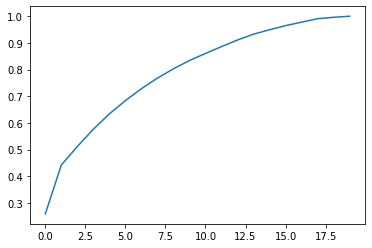

In [25]:
%matplotlib inline

from matplotlib import pyplot as plt

plt.plot(range(20), pca.explained_variance_ratio_.cumsum())
plt.show()

In [26]:
pca.explained_variance_ratio_.cumsum()

array([0.2590028 , 0.4424267 , 0.51161017, 0.57652743, 0.63390248,
       0.68359398, 0.72846105, 0.7680911 , 0.80302776, 0.83411104,
       0.8604245 , 0.88623497, 0.91098428, 0.9328969 , 0.94926481,
       0.96485529, 0.97790404, 0.99078593, 0.99608975, 1.        ])

In [27]:
pca.explained_variance_ratio_.cumsum()[12]

0.9109842843806883

Scendendo quindi da 20 a 13 feature si mantiene più del 90% della varianza

### Iniziamo comunque con tutte le 20 feature

In [28]:
risultati['Details'] = {model_to_string[m]: np.mean(addestra(m, X_details, y_details, g, 9, 9)) for m, g in zip(models, grids)}

--- 66.71055150032043 seconds ---
--- 5.063744068145752 seconds ---
--- 1245.8999691009521 seconds ---
--- 0.13771915435791016 seconds ---
--- 0.28455543518066406 seconds ---
--- 226.79020404815674 seconds ---


In [29]:
table = pd.DataFrame(risultati)
table

,Totali,Totali_with_BMI,Totali_with_data,Totali_with_date_and_bmi,Details
SVC,0.660847,0.668783,0.774603,0.736508,0.685714
DT,0.576720,0.593122,0.614286,0.669312,0.656085
RF,0.661905,0.646561,0.674603,0.659259,0.724339
NB,0.692593,0.685714,0.729101,0.751852,0.631746
LD,0.713228,0.689947,0.729101,0.720635,0.638624
MLP,0.675661,0.676190,0.706349,0.737037,0.576720


### Scendiamo a 13 feature con PCA

In [30]:
risultati['Details_reduce_PCA'] = {model_to_string[m]: np.mean(addestra(m, X_details, y_details, g, 9, 9, dim_reduction=PCA(n_components=13))) for m, g in zip(models, grids)}

--- 42.29517984390259 seconds ---
--- 5.472275733947754 seconds ---
--- 1330.5759057998657 seconds ---
--- 0.22817111015319824 seconds ---
--- 0.273662805557251 seconds ---
--- 261.6761267185211 seconds ---


In [31]:
table = pd.DataFrame(risultati)
table

,Totali,Totali_with_BMI,Totali_with_data,Totali_with_date_and_bmi,Details,Details_reduce_PCA
SVC,0.660847,0.668783,0.774603,0.736508,0.685714,0.678307
DT,0.576720,0.593122,0.614286,0.669312,0.656085,0.639683
RF,0.661905,0.646561,0.674603,0.659259,0.724339,0.694180
NB,0.692593,0.685714,0.729101,0.751852,0.631746,0.676720
LD,0.713228,0.689947,0.729101,0.720635,0.638624,0.592593
MLP,0.675661,0.676190,0.706349,0.737037,0.576720,0.601587


### Proviamo a ridurre le componenti a 10 con t-SNE

In [47]:
from sklearn.manifold import TSNE

In [33]:
risultati['Details_reduced_TSNE'] = {model_to_string[m]: np.mean(addestra(m, X_details, y_details, g, 9, 9, dim_reduction=TSNE(n_components=13, method='exact'))) for m, g in zip(models, grids)}

--- 1123.8145956993103 seconds ---
--- 9.835256814956665 seconds ---
--- 1829.244247674942 seconds ---
--- 2.142005205154419 seconds ---
--- 2.351525068283081 seconds ---
--- 214.97792530059814 seconds ---


# Usando come scaler StandardScaler

In [42]:
table = pd.DataFrame(risultati)
table

,Totali,Totali_with_BMI,Totali_with_data,Totali_with_date_and_bmi,Details,Details_reduce_PCA,Details_reduced_TSNE
SVC,0.660847,0.668783,0.774603,0.736508,0.685714,0.678307,0.568783
DT,0.576720,0.593122,0.614286,0.669312,0.656085,0.639683,0.599471
RF,0.661905,0.646561,0.674603,0.659259,0.724339,0.694180,0.501058
NB,0.692593,0.685714,0.729101,0.751852,0.631746,0.676720,0.539683
LD,0.713228,0.689947,0.729101,0.720635,0.638624,0.592593,0.469312
MLP,0.675661,0.676190,0.706349,0.737037,0.576720,0.601587,0.575132


# Usando come scaler MaxAbsScaler

In [44]:
from sklearn.preprocessing import MinMaxScaler

risultati_minMax_scaler = {}
risultati_minMax_scaler['Totali'] = {model_to_string[m]: np.mean(addestra(m, X_total, y_total, g, 9, 9, scaling=MinMaxScaler())) for m, g in zip(models, grids)}

--- 8.441014051437378 seconds ---
--- 7.607229232788086 seconds ---
--- 1589.9299466609955 seconds ---
--- 0.14927077293395996 seconds ---
--- 0.29023289680480957 seconds ---
--- 119.16060638427734 seconds ---


In [45]:
risultati_minMax_scaler['Totali_with_BMI'] = {model_to_string[m]: np.mean(addestra(m, X_total_with_BMI, y_total_with_BMI, g, 9, 9, scaling=MinMaxScaler())) for m, g in zip(models, grids)}

--- 8.052030086517334 seconds ---
--- 5.689673662185669 seconds ---
--- 1278.4874029159546 seconds ---
--- 0.13933682441711426 seconds ---
--- 0.29599523544311523 seconds ---
--- 128.89365649223328 seconds ---


In [46]:
risultati_minMax_scaler['Totali_with_DATA'] = {model_to_string[m]: np.mean(addestra(m, X_total_with_data,y_total_with_data, g, 9, 9, scaling=MinMaxScaler())) for m, g in zip(models, grids)}

--- 7.436563491821289 seconds ---
--- 5.239670276641846 seconds ---
--- 1293.733787059784 seconds ---
--- 0.13758325576782227 seconds ---
--- 0.24863386154174805 seconds ---
--- 162.46791052818298 seconds ---


In [47]:
risultati_minMax_scaler['Totali_with_BMI_and_DATA'] = {model_to_string[m]: np.mean(addestra(m, X_total_with_data_and_BMI,y_total_with_data_and_BMI, g, 9, 9, scaling=MinMaxScaler())) for m, g in zip(models, grids)}

--- 7.520539999008179 seconds ---
--- 5.290779113769531 seconds ---
--- 1280.7361137866974 seconds ---
--- 0.13857483863830566 seconds ---
--- 0.28117799758911133 seconds ---
--- 167.92868876457214 seconds ---


In [48]:
risultati_minMax_scaler['Details'] = {model_to_string[m]: np.mean(addestra(m, X_details, y_details, g, 9, 9, scaling=MinMaxScaler())) for m, g in zip(models, grids)}

--- 10.113598346710205 seconds ---
--- 5.153912305831909 seconds ---
--- 1253.8158628940582 seconds ---
--- 0.16030073165893555 seconds ---
--- 0.2762415409088135 seconds ---
--- 245.01755833625793 seconds ---


In [63]:
risultati_minMax_scaler['Details_reduce_PCA'] = {model_to_string[m]: np.mean(addestra(m, X_details, y_details, g, 9, 9, scaling=MinMaxScaler(), dim_reduction=PCA(n_components=13))) for m, g in zip(models, grids)}

--- 10.588154077529907 seconds ---
--- 6.114059686660767 seconds ---


KeyboardInterrupt: 

In [ ]:
risultati_minMax_scaler['Details_reduced_TSNE'] = {model_to_string[m]: np.mean(addestra(m, X_details, y_details, g, 9, 9, scaling=MinMaxScaler(), dim_reduction=TSNE(n_components=13, method='exact'))) for m, g in zip(models, grids)}

In [ ]:
table2 = pd.DataFrame(risultati_minMax_scaler)
table2

In [30]:
print("Risultati usando StandardScaler")
display(table)
print("Risultati usando MinMaxScaler")
display(table2)

Risultati usando StandardScaler


NameError: name 'table' is not defined

# Usando come scaler RobustScaler

In [41]:
from sklearn.preprocessing import RobustScaler
import pandas as pd

In [56]:
risultati_RobustScaler = {}
risultati_RobustScaler['Totali'] = {model_to_string[m]: np.mean(addestra(m, X_total, y_total, g, 9, 9, scaling=RobustScaler())) for m, g in zip(models, grids)}

KeyboardInterrupt: 

In [ ]:
risultati_RobustScaler['Totali_with_BMI'] = {model_to_string[m]: np.mean(addestra(m, X_total_with_BMI, y_total_with_BMI, g, 9, 9, scaling=RobustScaler())) for m, g in zip(models, grids)}

In [57]:
risultati_Robustscaler['Totali_with_DATA'] = {model_to_string[m]: np.mean(addestra(m, X_total_with_BMI, y_total_with_BMI, g, 9, 9, scaling=RobustScaler())) for m, g in zip(models, grids)}

KeyboardInterrupt: 

In [60]:
risultati_RobustScaler['Totali_with_BMI_and_DATA'] = {model_to_string[m]: np.mean(addestra(m, X_total_with_data_and_BMI,y_total_with_data_and_BMI, g, 9, 9, scaling=RobustScaler())) for m, g in zip(models, grids)}

KeyboardInterrupt: 

In [44]:
risultati_RobustScaler['Details'] = {model_to_string[m]: np.mean(addestra(m, X_details, y_details, g, 9, 9, scaling=RobustScaler())) for m, g in zip(models, grids)}

KeyboardInterrupt: 

In [45]:
risultati_RobustScaler['Details_reduce_PCA'] = {model_to_string[m]: np.mean(addestra(m, X_details, y_details, g, 9, 9, scaling=RobustScaler(), dim_reduction=PCA(n_components=13))) for m, g in zip(models, grids)}

KeyboardInterrupt: 

In [48]:
from sklearn.manifold import TSNE

risultati_RobustScaler['Details_reduced_TSNE'] = {model_to_string[m]: np.mean(addestra(m, X_details, y_details, g, 9, 9, scaling=RobustScaler(), dim_reduction=TSNE(n_components=13, method='exact'))) for m, g in zip(models, grids)}

KeyboardInterrupt: 

In [ ]:
table3 = pd.DataFrame(risultati_RobustScaler)
table3

In [ ]:
print("Risultati usando StandardScaler")
display(table)
print("Risultati usando MaxAbsScaler")
display(table2)
print("Risultati usando RobustScaler")
dispaly(table3)

# Proviamo ora a non usare uno SCALER

In [ ]:
import datetime as dt

dataset.DATA = dataset.DATA.apply(lambda d: (d - dt.datetime(1970,1,1)).days)

dataset.head()

In [ ]:
X_total_with_data_and_BMI = dataset[['DATA', 'SESSO', 'ANNI', 'PESO', 'ALTEZZA', 'BMI', 'Tot Testa', 'Tot Torace', 'Tot Addome', 'Tot Scheletro']]
y_total_with_data_and_BMI = dataset['Mezzo']

In [ ]:
risultati_senza_scaler = {}

In [ ]:
risultati_senza_scaler['Totali_with_date_and_bmi'] = {model_to_string[m]: np.mean(addestra(m, X_total_with_data_and_BMI, y_total_with_data_and_BMI, g, 9, 9,scaling=None)) for m, g in zip(models, grids)}